# Comparison of greenness scores
Felix Zaussinger | 29.07.2021

## Core Analysis Goal(s)
1. Check agreement of the old (clearly wrong!), updated and reference greenness scores

## Key Insight(s)
1. The updated and reference scores are very similar. On average, the updated ones
are slightly higher than the reference scores from the Vona 2018 publication appendix.
However, I can cover around 30 more occupations using the updated scores, so I will
stick with those.

In [1]:
import os
import sys
import logging
from pathlib import Path

import numpy as np
import scipy as sp
import statsmodels.api as sm
from statsmodels.formula.api import ols

%load_ext autoreload
%autoreload 2

import matplotlib as mpl
import matplotlib.pyplot as plt
%matplotlib inline
%config InlineBackend.figure_format = 'retina'

import seaborn as sns
sns.set_context("poster")
sns.set(rc={'figure.figsize': (16, 9.)})
sns.set_style("ticks")

import pandas as pd
pd.set_option("display.max_rows", 120)
pd.set_option("display.max_columns", 120)

logging.basicConfig(level=logging.INFO, stream=sys.stdout)

Define directory structure

In [2]:
# project directory
abspath = os.path.abspath('')
project_dir = str(Path(abspath).parents[0])

# sub-directories
data_raw = os.path.join(project_dir, "data", "raw")
data_interim = os.path.join(project_dir, "data", "interim")
data_processed = os.path.join(project_dir, "data", "processed")
figure_dir = os.path.join(project_dir, "reports", "figures")

Code ...

In [3]:
g1 = pd.read_excel(
    os.path.join(data_raw, "onet", "Onet_GreenTask_AppA.xlsx"),
    sheet_name="Occupations"
)

g2 = pd.read_excel(
    os.path.join(data_raw, "onet", "vona_2018_table_a1.xlsx"),
    sheet_name="Greenness"
)

In [4]:
g_all = pd.merge(
    g1,
    g2,
    on="onet_code",
    how="left"
)

g_all

,onet_code,title_x,occupation_type,n_new_green_tasks,n_existing_green_tasks,n_non_green_tasks,greenness_vona_2018,greenness_vona_2018_v2,title_y,greenness,total_spec_tasks,green_spec_tasks
0,11-1011.03,Chief Sustainability Officers,New Green N&E,18,0,0,1.000000,1.000000,Chief Sustainability Officers,1.000000,18.0,18.0
1,11-1021.00,General and Operations Managers,Green Enhanced Skills,1,1,15,0.133333,0.117647,General and Operations Managers,0.055556,18.0,1.0
2,11-2011.01,Green Marketers,New Green N&E,16,0,0,1.000000,1.000000,NaN,NaN,NaN,NaN
3,11-2021.00,Marketing Managers,Green Enhanced Skills,4,0,16,0.250000,0.200000,Marketing Managers,0.200000,20.0,4.0
4,11-3051.02,Geothermal Production Managers,New Green N&E,17,0,0,1.000000,1.000000,Geothermal Production Managers,1.000000,17.0,17.0
...,...,...,...,...,...,...,...,...,...,...,...,...
133,51-9199.01,Recycling and Reclamation Workers,New Green N&E,18,0,0,1.000000,1.000000,Recycling and Reclamation Workers,1.000000,18.0,18.0
134,53-1021.01,Recycling Coordinators,New Green N&E,23,0,0,1.000000,1.000000,NaN,NaN,NaN,NaN
135,53-3032.00,"Truck Drivers, Heavy and Tractor-Trailer",Green Enhanced Skills,3,0,28,0.107143,0.096774,Heavy and Tractor-Trailer Truck Drivers,0.090909,33.0,3.0
136,53-6051.07,"Transportation Vehicle, Equipment and Systems ...",Green Enhanced Skills,8,1,12,0.750000,0.428571,"Transportation Vehicle, Equipment and Systems ...",0.409091,22.0,9.0


In [3]:
df_metadata = pd.read_csv(
    os.path.join(data_interim, "ESCO_ONET_METADATA.csv"),
    index_col=0
)

In [6]:
skills = pd.read_csv(os.path.join(data_raw, "esco", "v1.0.3", "skills_en.csv"))

### Analysis 1
- create subset of occupations with greenness = 1
- count the number of times a skill is required (essential/optional) across those occupations

2       0.062500
10      0.047619
24      0.250000
28      0.342857
40      0.068966
          ...   
2923    0.285714
2929    1.000000
2932    0.135135
2935    0.047619
2938    1.000000
Name: greenness_vona_2018_v2, Length: 432, dtype: float64

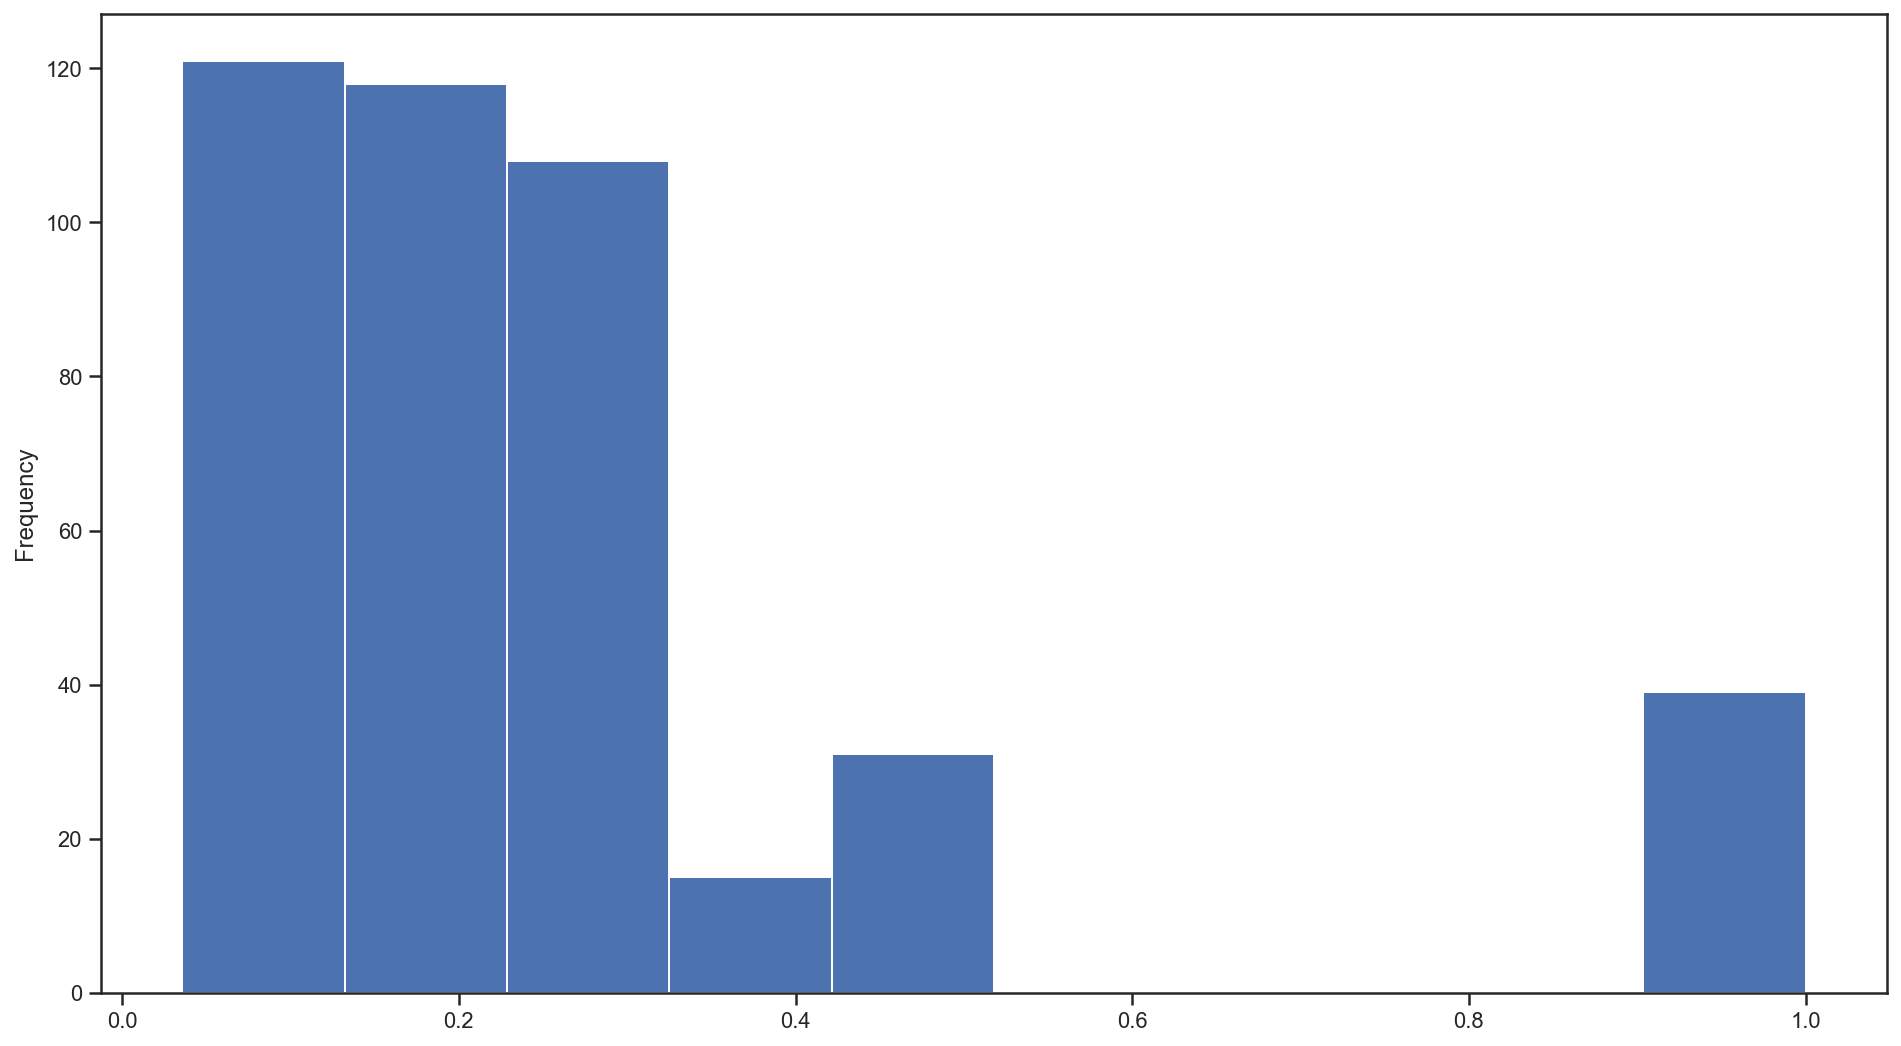

In [32]:
df_metadata.sort_values("greenness_vona_2018_v2", ascending=False).head(35)
df_metadata.greenness_vona_2018_v2.plot.hist()
df_metadata.greenness_vona_2018_v2.quantile(np.arange(0,1.1,0.1))

df_subset = df_metadata[df_metadata.greenness_vona_2018_v2 == 1]
df_subset
df_metadata.greenness_vona_2018_v2.dropna()

In [34]:
df_metadata.greenness_vona_2018_v2.describe()

count    432.000000
mean       0.278308
std        0.256745
min        0.035714
25%        0.096774
50%        0.219807
75%        0.300000
max        1.000000
Name: greenness_vona_2018_v2, dtype: float64

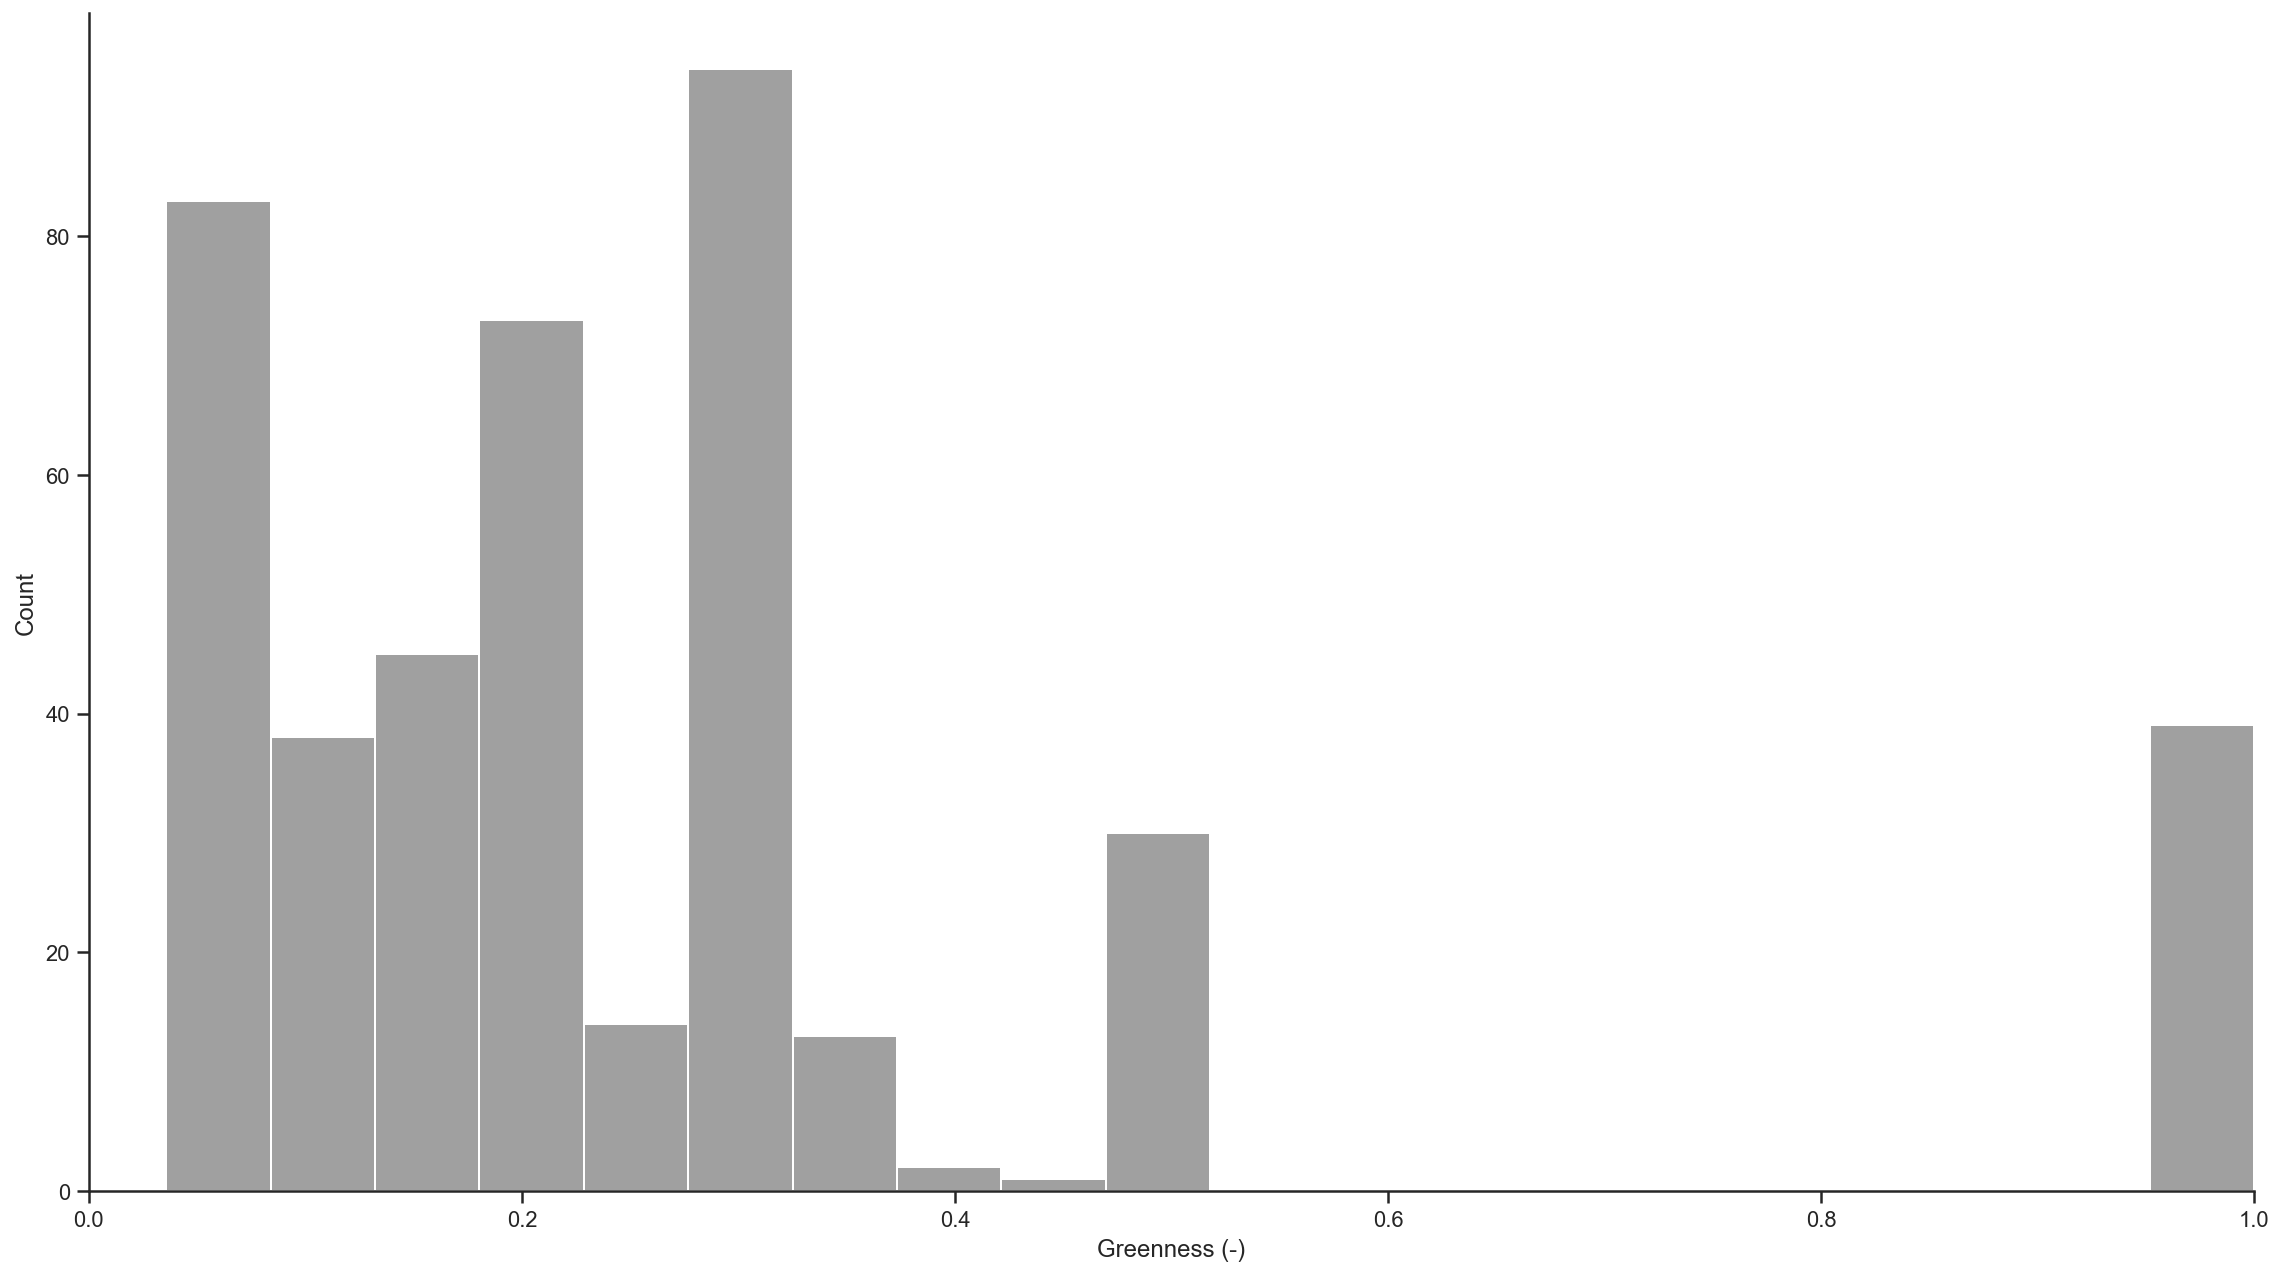

In [35]:
ax = sns.histplot(
    df_metadata.greenness_vona_2018_v2,
    stat="count",
    color="grey",
    bins=20,
)

ax.set_xlim(0, 1)
ax.set_xlabel("Greenness (-)")

sns.despine()
plt.tight_layout()

plt.savefig(
    os.path.join(figure_dir, "RQ2", "greenness_v2_histogram.png"),
    dpi=150,
    bbox_inches="tight"
)

In [47]:
occ_skills_matrix = pd.read_pickle(
        os.path.join(project_dir, "data", "processed", "adjacency_matrix.pkl")
)

occ_skills_matrix_eo = pd.read_pickle(
        os.path.join(project_dir, "data", "processed", "adjacency_matrix_essential_optional.pkl")
)

In [9]:
occ_skills_matrix_sub = occ_skills_matrix.iloc[df_subset.concept_uri.index.values,:]

In [11]:
skills["n_greenness_1"] = occ_skills_matrix_sub.sum(axis=0).values

In [13]:
skills_sub = skills[skills.n_greenness_1 > 1].sort_values("n_greenness_1", ascending=False)

### Prepare tables for thesis

In [14]:
skill_cols = ["preferredLabel", "reuseLevel", "n_greenness_1"]
skills_sub[skill_cols].head(30).reset_index(drop=True).to_csv(
    os.path.join(data_processed, "greenness_skills.csv")
)

In [15]:
occ_cols = ["preferred_label", "occupation_type", "greenness_vona_2018_v2"]
df_subset[occ_cols].reset_index(drop=True).to_csv(
    os.path.join(data_processed, "greenness_occupations.csv")
)

### Analysis 2
- replicate analysis 1 while differentiating between essential and optional skills

In [83]:
# occ_skills_matrix_eo_sub = occ_skills_matrix_eo.iloc[df_subset.concept_uri.index.values,:]
occ_skills_matrix_e = occ_skills_matrix_eo.replace(to_replace=2, value=0)
occ_skills_matrix_o = occ_skills_matrix_eo.replace(to_replace=1, value=0)
occ_skills_matrix_o = occ_skills_matrix_o.divide(2)

In [84]:
occ_skills_matrix_e_sub = occ_skills_matrix_e.iloc[df_subset.concept_uri.index.values,:]
occ_skills_matrix_o_sub = occ_skills_matrix_o.iloc[df_subset.concept_uri.index.values,:]

In [85]:
skills["n_greenness_1_essential"] = occ_skills_matrix_e_sub.sum(axis=0).values
skills["n_greenness_1_optional"] = occ_skills_matrix_o_sub.sum(axis=0).values

In [86]:
skills.sort_values("n_greenness_1_optional", ascending=False)

,conceptType,conceptUri,skillType,reuseLevel,preferredLabel,altLabels,hiddenLabels,status,modifiedDate,scopeNote,definition,inScheme,description,n_greenness_1,n_greenness_all,n_greenness_weighted,n_greenness_1_essential,n_greenness_1_optional
6292,KnowledgeSkillCompetence,http://data.europa.eu/esco/skill/75f312e1-622b...,knowledge,cross-sector,pollution prevention,regulations for pollution prevention\nInternat...,NaN,released,2017-01-05T16:50:21Z,NaN,NaN,http://data.europa.eu/esco/concept-scheme/memb...,The processes used to prevent pollution: preca...,13,17,16.22,3,10.0
7384,KnowledgeSkillCompetence,http://data.europa.eu/esco/skill/8abdc43c-2bfd...,skill/competence,cross-sector,promote environmental awareness,promoting environmental awareness\nendorse env...,NaN,released,2017-02-10T17:31:05Z,NaN,NaN,http://data.europa.eu/esco/concept-scheme/memb...,Calculate the carbon footprint of business pro...,16,20,18.31,6,10.0
5184,KnowledgeSkillCompetence,http://data.europa.eu/esco/skill/6122d586-5978...,skill/competence,cross-sector,wear appropriate protective gear,clothe in appropriate protective gear\nput on ...,NaN,released,2016-12-20T19:52:20Z,NaN,NaN,http://data.europa.eu/esco/concept-scheme/memb...,"Wear relevant and necessary protective gear, s...",12,14,17.60,2,10.0
3455,KnowledgeSkillCompetence,http://data.europa.eu/esco/skill/40fa39b5-0f69...,skill/competence,cross-sector,dispose of hazardous waste,eliminate dangerous waste\nremove hazardous wa...,NaN,released,2016-12-20T19:49:43Z,NaN,NaN,http://data.europa.eu/esco/concept-scheme/memb...,Dispose of dangerous materials such as chemica...,8,8,8.99,0,8.0
11672,KnowledgeSkillCompetence,http://data.europa.eu/esco/skill/de131ede-cbfe...,skill/competence,sector-specific,report pollution incidents,report incidents of pollution\nreporting pollu...,NaN,released,2016-12-20T17:30:10Z,NaN,NaN,http://data.europa.eu/esco/concept-scheme/skil...,"When an incident causes pollution, examine the...",9,9,9.12,1,8.0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
4579,KnowledgeSkillCompetence,http://data.europa.eu/esco/skill/55d42108-1d7e...,knowledge,occupation-specific,screw manufacturing processes,screw manufacturing processes\nscrew manufactu...,NaN,released,2017-01-06T11:15:40Z,NaN,NaN,http://data.europa.eu/esco/concept-scheme/skil...,The various manufacturing processes performed ...,0,0,0.00,0,0.0
4580,KnowledgeSkillCompetence,http://data.europa.eu/esco/skill/55d46c76-385c...,skill/competence,sector-specific,analyse apple juice for cider production,test apple juice for cider production\nsearch ...,NaN,released,2017-01-05T09:55:21Z,NaN,NaN,http://data.europa.eu/esco/concept-scheme/memb...,Analyse apple juice before fermentation and th...,0,0,0.10,0,0.0
4581,KnowledgeSkillCompetence,http://data.europa.eu/esco/skill/55dda75d-698c...,skill/competence,sector-specific,protect health and safety when handling animals,ensure health and safety when handling animals...,NaN,released,2016-12-20T21:19:08Z,NaN,NaN,http://data.europa.eu/esco/concept-scheme/skil...,Protect health and welfare of animals and thei...,0,0,0.00,0,0.0
4582,KnowledgeSkillCompetence,http://data.europa.eu/esco/skill/55e286cf-b8a0...,knowledge,sector-specific,types of aircraft,brands of aircraft\nvarieties of aircraft\ntyp...,NaN,released,2016-12-20T20:45:07Z,NaN,NaN,http://data.europa.eu/esco/concept-scheme/skil...,"The various types of aircraft, their functiona...",0,0,1.01,0,0.0


In [88]:
pd.set_option('precision', 2)
skills.loc[:, skills.columns.str.startswith("n_")].corr(method="spearman")

,n_greenness_1,n_greenness_all,n_greenness_weighted,n_greenness_1_essential,n_greenness_1_optional
n_greenness_1,1.00,0.78,0.42,0.75,0.84
n_greenness_all,0.78,1.00,0.53,0.59,0.66
n_greenness_weighted,0.42,0.53,1.00,0.32,0.36
n_greenness_1_essential,0.75,0.59,0.32,1.00,0.43
n_greenness_1_optional,0.84,0.66,0.36,0.43,1.00


### Analysis 3
- count the number of times a skill is required (essential/optional) across all occupations
- multiply this number by the greenness of the occupation

In [25]:
df_subset_2 = df_metadata[df_metadata.greenness_vona_2018_v2 > 0.4]
occ_skills_matrix_sub_2 = occ_skills_matrix.iloc[df_subset_2.concept_uri.index.values,:]

In [43]:
s = df_metadata.greenness_vona_2018_v2.fillna(0)
occ_skills_matrix_weighted = occ_skills_matrix.apply(lambda x: np.asarray(x) * np.asarray(s), axis=0)

In [44]:
skills["n_greenness_weighted"] = occ_skills_matrix_weighted.sum(axis=0).values

In [74]:
skills.sort_values("n_greenness_all", ascending=False).head(30)


,conceptType,conceptUri,skillType,reuseLevel,preferredLabel,altLabels,hiddenLabels,status,modifiedDate,scopeNote,definition,inScheme,description,n_greenness_1,n_greenness_all,n_greenness_weighted,n_greenness_1_essential,n_greenness_1_optional
4223,KnowledgeSkillCompetence,http://data.europa.eu/esco/skill/4fabca9a-7435...,skill/competence,cross-sector,perform scientific research,performing scientific research\nengage in scie...,NaN,released,2016-12-20T20:21:53Z,NaN,NaN,http://data.europa.eu/esco/concept-scheme/memb...,"Gain, correct or improve knowledge about pheno...",12,28,34.003192,10,4
4478,KnowledgeSkillCompetence,http://data.europa.eu/esco/skill/541561bc-510c...,skill/competence,cross-sector,use technical drawing software,design with specialist software\ndesign using ...,NaN,released,2016-12-20T19:55:25Z,NaN,NaN,http://data.europa.eu/esco/concept-scheme/skil...,Create technical designs and technical drawing...,12,20,29.575797,11,2
7384,KnowledgeSkillCompetence,http://data.europa.eu/esco/skill/8abdc43c-2bfd...,skill/competence,cross-sector,promote environmental awareness,promoting environmental awareness\nendorse env...,NaN,released,2017-02-10T17:31:05Z,NaN,NaN,http://data.europa.eu/esco/concept-scheme/memb...,Calculate the carbon footprint of business pro...,16,20,18.314054,6,20
424,KnowledgeSkillCompetence,http://data.europa.eu/esco/skill/089ee650-297e...,skill/competence,cross-sector,ensure compliance with environmental legislation,lead implementation of environmental policies ...,NaN,released,2017-02-10T18:22:50Z,NaN,NaN,http://data.europa.eu/esco/concept-scheme/memb...,Monitor activities and perform tasks ensuring ...,12,20,20.274299,7,10
4781,KnowledgeSkillCompetence,http://data.europa.eu/esco/skill/59ea80e1-463a...,knowledge,cross-sector,technical drawings,mechanical drawings\nspecialised drawings\ntec...,NaN,released,2016-12-20T19:12:04Z,NaN,NaN,http://data.europa.eu/esco/concept-scheme/skil...,"Drawing software and the various symbols, pers...",11,20,26.385065,11,0
1705,KnowledgeSkillCompetence,http://data.europa.eu/esco/skill/209a5498-3449...,knowledge,cross-sector,engineering principles,engineering research principles\nengineering w...,NaN,released,2017-01-04T15:30:28Z,NaN,NaN,http://data.europa.eu/esco/concept-scheme/memb...,"The engineering elements like functionality, r...",10,19,32.825462,9,2
3535,KnowledgeSkillCompetence,http://data.europa.eu/esco/skill/42b23922-1c40...,skill/competence,cross-sector,adjust engineering designs,adjust manufacturing designs\nadjust construct...,NaN,released,2016-12-20T20:04:35Z,NaN,NaN,http://data.europa.eu/esco/concept-scheme/skil...,Adjust designs of products or parts of product...,11,18,27.782042,11,0
6117,KnowledgeSkillCompetence,http://data.europa.eu/esco/skill/72a74f69-5cf1...,knowledge,sector-specific,engineering processes,NaN,NaN,released,2016-09-02T10:02:19Z,NaN,NaN,http://data.europa.eu/esco/concept-scheme/memb...,The systematic approach to the development and...,11,17,27.857758,11,0
6292,KnowledgeSkillCompetence,http://data.europa.eu/esco/skill/75f312e1-622b...,knowledge,cross-sector,pollution prevention,regulations for pollution prevention\nInternat...,NaN,released,2017-01-05T16:50:21Z,NaN,NaN,http://data.europa.eu/esco/concept-scheme/memb...,The processes used to prevent pollution: preca...,13,17,16.220420,3,20
12896,KnowledgeSkillCompetence,http://data.europa.eu/esco/skill/f54c10e4-630d...,skill/competence,cross-sector,approve engineering design,produce engineering design\ndevelop engineerin...,NaN,released,2016-12-20T20:52:02Z,NaN,NaN,http://data.europa.eu/esco/concept-scheme/skil...,Give consent to the finished engineering desig...,10,17,23.818993,10,0


In [80]:
df_metadata[df_metadata.greenness_vona_2018_v2 > 0].shape

(432, 34)

In [89]:
skill_cols = ["preferredLabel", "reuseLevel", "n_greenness_1_essential"]
skills[skill_cols].sort_values("n_greenness_1_essential", ascending=False).head(30).reset_index(drop=True).to_csv(
    os.path.join(data_processed, "greenness_skills_essential.csv")
)

skill_cols = ["preferredLabel", "reuseLevel", "n_greenness_1_optional"]
skills[skill_cols].sort_values("n_greenness_1_optional", ascending=False).head(30).reset_index(drop=True).to_csv(
    os.path.join(data_processed, "greenness_skills_optional.csv")
)

skill_cols = ["preferredLabel", "reuseLevel", "n_greenness_all"]
skills[skill_cols].sort_values("n_greenness_all", ascending=False).head(30).reset_index(drop=True).to_csv(
    os.path.join(data_processed, "greenness_skills_all.csv")
)

pd.set_option('precision', 2)
skill_cols = ["preferredLabel", "reuseLevel", "n_greenness_weighted"]
skills[skill_cols].sort_values("n_greenness_weighted", ascending=False).head(30).reset_index(drop=True).to_csv(
    os.path.join(data_processed, "greenness_skills_weighted.csv"),
    float_format='%.2f'
)

